# Progetto Machine Learning: Analisi Dataset Immagini

Emilio Casella matr.204898                                                                                      

## Caricamento del Dataset

Il dataset comprende quattro tipologie di immagini da analizzare: jeans,shirts,trousers,watches.

Le immagini vengono caricate in scala di grigio, normalizzate e "flattenizzate" in un array numpy, in modo da agevolare le operazioni successive.

In [1]:
import os
import glob
import numpy as np
import cv2
from PIL import Image as I
import tensorflow as tf
import pandas as pd
import random
import operator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,precision_score,recall_score,roc_curve,auc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold,cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers  
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import pickle as pkl
import warnings
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Activation,Conv2D,MaxPooling2D,Flatten,Dropout,MaxPool2D
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.inception_v3 import InceptionV3
import torch
from torchvision import datasets, transforms
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import label_binarize

In [2]:
PATH="/home/emiliocasella/Scrivania/proj204898/immagini-2/"

In [3]:
def loadD(PATH):
    data=[]
    fnames=glob.glob(PATH+'//*_*.jpg')
    i,j=cv2.imread(fnames[0],0).shape
    target=[os.path.basename(t).split("_")[0] for t in fnames]
    for f in fnames:
        img=cv2.imread(f,0)
        img = cv2.resize(img, (i, j))
        data.append(img)
    return np.array(data).reshape(len(data),i*j)/255,np.array(target).reshape(len(data)),i,j

Il dataset è formato da (#esempi x (80 x 60), target)

In [4]:
X,y,i,j=loadD(PATH)

I seguenti metodi facilitano le operazioni di salvataggio/ripristino dei modelli.

In [19]:
def saveM(model,fname):
    fname=fname+'.model'
    pkl.dump(model, open(fname, 'wb'))

def loadM(fname):
    return pkl.load(open(fname+'.model', 'rb'))

def saveNN(model,fname):
    json_model = model.to_json()
    open(fname + '.json', 'w').write(json_model)
    model.save_weights(fname + '.h5', overwrite=True)

def loadNN(fname):
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model = model_from_json(open(fname+'.json').read())
    model.load_weights(fname+'.h5')
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def loadClass():
    return pd.read_csv("/home/emiliocasella/Scrivania/proj204898/img/10fold.csv")


## Tuning dei modelli SVC,ADABOOST e KNN


Si presentano i primi classificatori scelti: SVC, AdaBoost, KNN; lanciando una serie di configurazioni diverse per capire 
quale si adatta meglio al problema in analisi e massimizzare i risultati successivi.

Il Support Vector Machine (SVM) è un algoritmo di apprendimento automatico supervisionato che può essere utilizzato sia per scopi di classificazione che di regressione. 

Il Support Vector Machine ha l’obiettivo di identificare l’iperpiano che meglio divide i vettori di supporto in classi. Per farlo esegue i seguenti step:

-Cerca un iperpiano linearmente separabile o un limite di decisione che separa i valori di una classe dall’altro. Se ne esiste più di uno, cerca quello che ha margine più alto con i vettori di supporto, per migliorare l’accuratezza del modello.

-Se tale iperpiano non esiste, SVM utilizza una mappatura non lineare per trasformare i dati di allenamento in una dimensione superiore (se siamo a due dimensioni, valuterà i dati in 3 dimensioni). In questo modo, i dati di due classi possono sempre essere separati da un iperpiano, che sarà scelto per la suddivisione dei dati.

AdaBoost, acronimo di “Adaptive Boosting” rappresenta una tecnica di boosting popolare che aiuta a combinare più “classificatori deboli” in un unico “classificatore forte”.

Per intenderci, un classificatore debole è semplicemente un classificatore che funziona male, ma funziona meglio di un’ipotesi casuale.

Mettendo insieme tanti modelli di questo tipo, l’AdaBoost riesce a generarne uno che complessivamente è migliore dei singoli classificatori deboli presi singolarmente.

Come classificatore debole da addestrare l’Adaboost si avvale di tanti alberi decisionali ad un livello di profondità, definiti decision stumps, tanti quanti sono le caratteristiche del modello.

Ad ogni iterazione, un nuovo classificatore debole viene introdotto in sequenza e mira a compensare le “carenze” dei modelli precedenti per creare un forte classificatore. L’obiettivo generale di questo esercizio è quello di adattare consecutivamente nuovi modelli per fornire stime più accurate della nostra variabile di risposta.

In realtà l’AdaBoost non accetta solo alberi decisionali come weak learners: qualsiasi algoritmo di apprendimento automatico può essere utilizzato come classificatore di base se accetta pesi sul set di allenamento.

Si noti che nella configurazione scelta, l'albero ha profondità 1, per emulare i decision stump; con l'utilizzo dell'algoritmo SAMME.R, che si adatta meglio ad un problema multiclasse.

KNN è un algoritmo di apprendimento supervisionato, il cui scopo è quello di predire una nuova istanza conoscendo i data points che sono separati in diverse classi.

Il funzionamento dell’algoritmo K-Nearest Neighbors può essere definito tramite i seguenti step:

1) Si sceglie un valore k con cui prevedere il nuovo data point;

2) Nel caso di grandezze non comparabili si utilizzano tecniche per rendere le misure confrontabili, come la normalizzazione;

3) Si calcola la distanza tra la nuova istanza e i vari data points;

4) Si ordinano le distanze calcolate dalla più piccola alla più grande;

5) Si scelgono le prime K: nel caso si stia svolgendo un problema di regressione, si può restituire con la media delle etichette K. Se si sta svolgendo un problema di classificazione, si sceglierà la classe che include più valori k trovati precedentemente.




In [6]:
def tuningAdaBoostClassifier(X_train,y_train):
    param_ada_grid={'n_estimators':[10,50,100,500],
                    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0],
                   }
    ada=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm='SAMME.R')
    grid_search=GridSearchCV(ada,param_ada_grid,scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Param:", grid_search.best_params_)
    best_ada = grid_search.best_estimator_
    return best_ada


def tuningKNN(X_train,y_train,knn):
    params = {'n_neighbors': range(1, 21, 2),
              'weights':['uniform','distance'],
              'metric':['euclidean', 'manhattan', 'minkowski']
             }
    grid_search = GridSearchCV(knn, params,scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Param:", grid_search.best_params_)
    best_KNN = grid_search.best_estimator_
    return best_KNN

def tuningSVC(X_train,y_train,svc):
    param_svc_grid ={'kernel': ['poly', 'linear', 'rbf','sigmoid'],
                      'C' : [500, 300 ,200, 150, 100, 50, 10, 1],
                     'gamma': ['scale']
                    }
    grid_search = GridSearchCV(svc, param_svc_grid,scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Param:", grid_search.best_params_)
    best_svc = grid_search.best_estimator_
    return best_svc


class MyClassificatorTrain(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self

    def transform(self, X,y):
        X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                     test_size=0.2,shuffle=True)
        print("Training modelli...")
        print("AdaBoost...")
        ada_best=tuningAdaBoostClassifier(X_train,y_train)
        print("Tuning SVC...")
        svc_clf=SVC()
        svc_best = tuningSVC(X_train,y_train,svc_clf)
        print("Tuning KNN...")
        knn_clf=KNeighborsClassifier()
        knn_best=tuningKNN(X_train,y_train,knn_clf)
        print("Fatto!")

    
      

AdaBoost è settato con un learning rate piuttosto alto, 1.0 e molti stimatori, 500.

Per quanto concerne SVC, ottengo un C pari a 150 dove C,misura "dimensione" del vettore coefficiente stesso alla funzione, è essenzialmente l'inverso del peso sul termine di "regolarizzazione". Diminuendo C si eviterà il sovradimensionamento forzando i coefficienti a essere piccoli o sparsi, a seconda della penalità. L'aumento eccessivo di C promuoverà il underfitting.

Il kernel RBF (Radial Basis Function) è anche chiamato il kernel gaussiano più complesso; contiene un parametro γ: un piccolo valore di γ farà sì che il modello si comporti come un SVM lineare, mentre un grande valore di γ renderà il modello fortemente influenzato dagli esempi dei vettori di supporto.

Gamma,appunto, è un parametro per il kernel RBF. L'aumento della gamma consente un limite decisionale più complesso, qui settato a scale, ovvero 1 / (n_features * variance di X).

KNN utilizzerà 3 vicini e classificherà i punti in base alla distanza di Manhattan.



In [7]:
MyClassificatorTrain().transform(X,y)

Training modelli...
AdaBoost...
Best Param: {'learning_rate': 1.0, 'n_estimators': 500}
Tuning SVC...
Best Param: {'C': 150, 'gamma': 'scale', 'kernel': 'rbf'}
Tuning KNN...
Best Param: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Fatto!


## Rete Neurale 

Si è scelto di utilizzare una rete convoluzionale, più indicata per l'analisi delle immagini.
La rete è composta da tre blocchi sequenziali, composti da layers convoluzional, di max pooling e normalizzazione batch.

Ciascun livello convoluzionale avrà un passo di uno strides=1, l'impostazione predefinita per Conv2D.
I livelli di attivazione sono definiti nel metodo Conv2D e utilizzano un'unità lineare rettificata (ReLU).

Tutti i blocchi convoluzionali useranno una dimensione della finestra del filtro di 5x5, tranne il blocco convoluzionale finale, che utilizza una dimensione della finestra di 3x3.

Tra il secondo e il terzo livello e dopo quest'ultimo, si è deciso di inserire uno strato di normalizzazione batch al posto dei classici livelli di dropout, per standardizzare e normalizzare i valori ricevuti mitigando l'effetto di gradienti instabili all'interno di reti neurali profonde.

Dopo questi blocchi si utilizza la flattenizzazione.

Successivamente vengono utilizzati 2 layer densi con dropout di 0.25 alla fine del secondo strato di 100 unità.

Infine, poiché si tratta di un problema multi-classe, il nostro livello completamente connesso ha una funzione di attivazione Softmax con 4 neuroni.

La funzione di loss scelta è la sparse_categorical_crossentropy, utile per i problemi multiclasse, con ottimizzatore Adam settato ad un learning rate di 0.001.

In [7]:
def create_network():
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model_conv = keras.Sequential()
    model_conv.add(layers.Conv2D(25, (5, 5), activation='relu', input_shape=(i, j, 1)))
    model_conv.add(layers.MaxPooling2D((2, 2)))
    model_conv.add(layers.Conv2D(50, (5, 5), activation='relu'))
    model_conv.add(layers.MaxPooling2D((2, 2)))
    model_conv.add(layers.BatchNormalization())
    model_conv.add(layers.Conv2D(70, (3, 3), activation='relu'))
    model_conv.add(layers.MaxPooling2D((2, 2)))
    model_conv.add(layers.BatchNormalization())
    model_conv.add(layers.Flatten())
    model_conv.add(Dense(units=100, activation='relu'))
    model_conv.add(Dense(units=100, activation='relu'))
    model_conv.add(Dropout(0.25))
    model_conv.add(layers.Dense(4, activation='softmax'))
    model_conv.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy']);
    return model_conv


def preNN(X,y,i,j):
    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)
    y = to_categorical(y)    
    y = np.argmax(y, axis=1)
    X = X.reshape((len(X),i,j,1))
    return X,y


def tuningNN(X_train, X_test, y_train, y_test,epochs):
    model = create_network()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.000001)
    history=model.fit(X_train,y_train,epochs=epochs,validation_data = (X_test,y_test),callbacks=[reduce_lr],verbose=1)
  
   
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

     

class MyClassificatorTrainNN(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return self

    def transform(self, X,y,epochs):
        print("Preprocessing per NN...")
        X,y=preNN(X,y,i,j)
        X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                        test_size=0.2,shuffle=True) 
        print("Tuning NN...")
        tuningNN(X_train, X_test, y_train, y_test,epochs)
        print("Fatto!") 

Viene studiata la loss su una divisione di prova per 20 epoche, per capire le epoche necessarie al training del modello.
Per evitare fenomeni di overfitting, il tutto viene controllato dalla funzione ReduceLROnPlateau che, non appena la rete smette di apprendere, abbassa il learning rate.

Preprocessing per NN...
Tuning NN...
Epoch 1/20
156/156 [==============================] - 21s 130ms/step - loss: 0.3621 - accuracy: 0.8578 - val_loss: 2.0911 - val_accuracy: 0.4440
Epoch 2/20
156/156 [==============================] - 18s 114ms/step - loss: 0.1523 - accuracy: 0.9443 - val_loss: 0.4750 - val_accuracy: 0.8106
Epoch 3/20
156/156 [==============================] - 18s 113ms/step - loss: 0.1336 - accuracy: 0.9490 - val_loss: 0.2994 - val_accuracy: 0.8807
Epoch 4/20
156/156 [==============================] - 18s 113ms/step - loss: 0.0618 - accuracy: 0.9748 - val_loss: 0.6364 - val_accuracy: 0.7953
Epoch 5/20
156/156 [==============================] - 18s 114ms/step - loss: 0.0459 - accuracy: 0.9821 - val_loss: 0.1248 - val_accuracy: 0.9589
Epoch 6/20
156/156 [==============================] - 18s 114ms/step - loss: 0.0348 - accuracy: 0.9866 - val_loss: 0.0945 - val_accuracy: 0.9742
Epoch 7/20
156/156 [==============================] - 18s 113ms/step - loss: 0.0329 - accurac

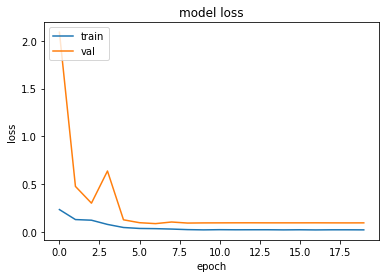

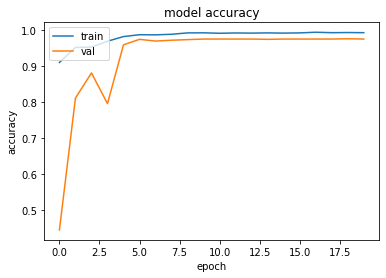

Fatto!


In [8]:
MyClassificatorTrainNN().transform(X,y,20)

La scelta ricade su 17 epoche.

## Accuratezza sulla 10-fold cross-validation

Come da richiesta progettuale, viene effettuata una validazione incrociata con 10 "sacche".
Per assicurare una maggiore affidabilità ai risultati, si utilizza una KFold stratificata, permettendo che una classe di dati non sia sovrapesata soprattutto quando la variabile target è sbilanciata; riducendo,inoltre, bias e varianza.

In [8]:
strkf=StratifiedKFold(n_splits=10)
score_KFold=[]

Per ogni classificatore, verrà salvato il modello che mostra lo score di accuratezza maggiore su una delle dieci divisioni.

Si mostra lo score di accuratezza media e la deviazione std ottenuti dal modello sulla 10fold cross validation.

Successivamente, verranno mostrati i risultati ottenuti sul test set relativo al miglior classificatore,tramite lo studio di:

1)Precision: La precisione è l’abilità di un classificatore di non etichettare un’istanza positiva che è in realtà negativa. Per ogni classe è definito come il rapporto tra veri positivi e la somma di veri e falsi positivi;

2)Recall: detta anche sensitivity o true positive, è la capacità di un classificatore di trovare tutte le istanze positive. Per ogni classe è definito come il rapporto tra i veri positivi e la somma dei veri positivi e dei falsi negativi;

3)F-score: è una media armonica ponderata delle metriche Precision e Recall in modo tale che il punteggio migliore sia 1 e il peggiore sia 0;

4)Matrice di confusione: permette di visualizzare meglio il rapporto tra TP,FP,TN,FN;

5)Curve di ROC: costruita considerando tutti i possibili valori del test e, per ognuno di questi, si calcola la proporzione di veri positivi (la sensibilità) e la proporzione di falsi positivi. La proporzione di falsi positivi si calcola con la formula standard: 1 - specificità. Congiungendo i punti che mettono in rapporto la proporzione di veri positivi e di falsi positivi (le cosiddette coordinate) si ottiene una curva chiamata curva ROC. L’area sottostante alla curva ROC (AUC, acronimo dei 
termini inglesi “Area Under the Curve”) è una misura di accuratezza diagnostica.
L’area sotto la curva può assumere valori compresi tra 0.5 e 1.0. Tanto maggiore è l’area sotto la curva (cioè tanto più la curva si avvicina al vertice del grafico) tanto maggiore è il potere discriminante del test. Per l’interpretazione dei valori dell’area sottostante la curva ROC è possibile riferirsi alla classificazione proposta:
- AUC=0.5 il test non è informativo;
- 0.5<AUC≤0.7 il test è poco accurato;
- 0.7<AUC≤0.9 il test è moderatamente accurato;
- 0.9<AUC<1.0 il test è altamente accurato;
- AUC=1 test perfetto.

In [9]:
def trasformN(y_test,pred):
    diz={'jeans':0,'shirts':1,'trousers':2,'watches':3}
    y_test_n=[]
    pred_n=[]
    for i in y_test:
        y_test_n.append(diz[i])
    for j in pred:
        pred_n.append(diz[j])
    return label_binarize(y_test_n, classes=[0,1,2,3]),label_binarize(pred_n, classes=[0,1,2,3])

def confusionMat(clf,X_test,y_test,typeC):
    if (typeC==1):
        pred = np.argmax(clf.predict(X_test), axis=-1)
    else:
        pred = clf.predict(X_test)
    score=accuracy_score(y_test, pred)
    ax =sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.1f', cmap=sns.color_palette("Reds", 25))
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) 
    plt.show()
    print(classification_report(y_test, pred))
    if (typeC==0):
        y_test,pred=trasformN(y_test,pred)
    else:
         y_test,pred=label_binarize(y_test, classes=[0,1,2,3]),label_binarize(pred, classes=[0,1,2,3])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    labels=['jeans','shirts','trousers','watches']
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(4):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Roc Curve class ' + labels[i])
        plt.legend(loc="lower right")
        plt.show()

def compute_performance(estimator,strkf,X, y,i,j):
    score = cross_validate(estimator, X ,y,cv=strkf ,scoring='accuracy',return_estimator=True,n_jobs=-1)
    model=score['estimator']
    results=score['test_score']
    mean_accuracy=np.round(np.mean(results),3)
    mean_std= np.round(np.std(results),3)
    maxAcc=np.round((np.max(results)),3)
    argMaxAcc=np.argmax(results)
    saveM(model[argMaxAcc],estimator.__class__.__name__)
    print("L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore ")
    print(results)
    print("Ottenendo un'accuratezza media di " + str(mean_accuracy)+" con deviazione standard di "+ str(mean_std))
    print("La migliore accuratezza e' "+ str(maxAcc) + " ottenuta nello split numero " + str(argMaxAcc+1))
    print("Salvo il modello ottenuto nello split numero " + str(argMaxAcc+1))
    print("Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero " + str(argMaxAcc+1))
    test_fold=[]
    for train_index, test_index in strkf.split(X, y):
            test_fold.append(test_index)
    confusionMat(model[argMaxAcc],X[test_fold[argMaxAcc]],y[test_fold[argMaxAcc]],0)
    return (mean_accuracy,mean_std)



def compute_performance_nn(estimator,strkf,X,y,i,j):
    model_fold=[]
    test_fold=[]
    acc_fold=[]
    loss_fold=[]
    X,y=preNN(X,y,i,j)
    fold_no = 1
    for train, test in strkf.split(X,y):
            model = create_network()
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.000001)
            history=model.fit(X[train],y[train],epochs=17,validation_data = (X[test],y[test]),callbacks=[reduce_lr],verbose=0)
            scores = model.evaluate(X[test], y[test], verbose=0)
            acc_fold.append(scores[1])
            loss_fold.append(scores[0])
            test_fold.append(test)
            model_fold.append(model)
            fold_no = fold_no + 1
    mean_accuracy=np.round(np.mean(acc_fold),3)
    mean_std= np.round(np.std(acc_fold),3)
    maxAcc=np.round((np.max(acc_fold)),3)
    argMaxAcc=np.argmax(acc_fold)
    print('Score per fold')
    saveNN(model_fold[argMaxAcc],"NN")
    print("L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore ")
    print(acc_fold)
    print("Ottenendo un'accuratezza media di " + str(mean_accuracy)+" con deviazione standard di "+ str(mean_std))
    print("La migliore accuratezza e' "+ str(maxAcc) + " ottenuta nello split numero " + str(argMaxAcc+1))
    
    
    
    print("Salvo il modello ottenuto nello split numero " + str(argMaxAcc+1))
    print("Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero " + str(argMaxAcc+1))
    confusionMat(model_fold[argMaxAcc],X[test_fold[argMaxAcc]],y[test_fold[argMaxAcc]],1)
    return (mean_accuracy,mean_std)
    
    
    

## Risultati ottenuti

L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.9178744  0.8921095  0.9178744  0.91465378 0.91935484 0.93064516
 0.94032258 0.92258065 0.91774194 0.92741935]
Ottenendo un'accuratezza media di 0.92 con deviazione standard di 0.012
La migliore accuratezza e' 0.94 ottenuta nello split numero 7
Salvo il modello ottenuto nello split numero 7
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 7


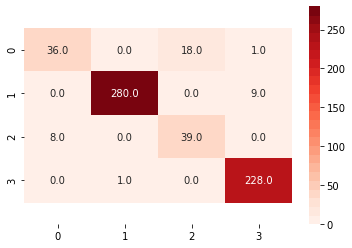

              precision    recall  f1-score   support

       jeans       0.82      0.65      0.73        55
      shirts       1.00      0.97      0.98       289
    trousers       0.68      0.83      0.75        47
     watches       0.96      1.00      0.98       229

    accuracy                           0.94       620
   macro avg       0.86      0.86      0.86       620
weighted avg       0.94      0.94      0.94       620



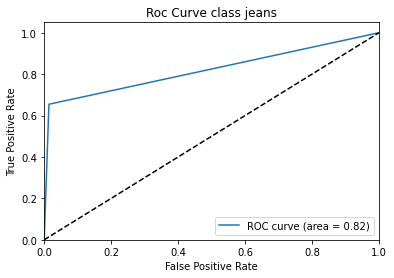

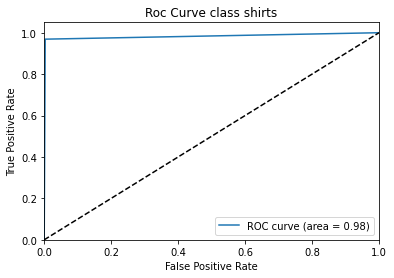

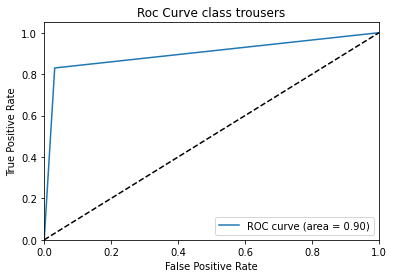

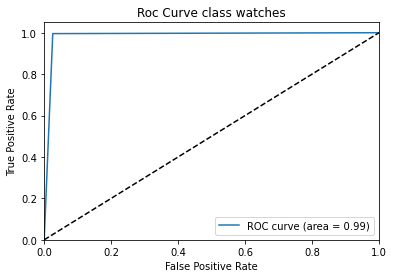

In [13]:
clf_ada=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=500, learning_rate=1.0,algorithm='SAMME.R')
mean_ada,std_ada=compute_performance(clf_ada,strkf,X, y,i,j)
score_KFold.append((mean_ada,std_ada))

L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.97101449 0.97584541 0.97584541 0.97584541 0.98387097 0.98064516
 0.98225806 0.97741935 0.97258065 0.97419355]
Ottenendo un'accuratezza media di 0.977 con deviazione standard di 0.004
La migliore accuratezza e' 0.984 ottenuta nello split numero 5
Salvo il modello ottenuto nello split numero 5
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 5


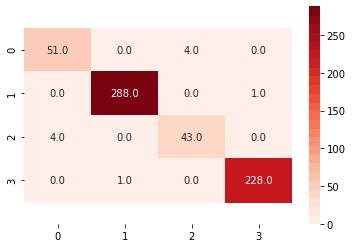

              precision    recall  f1-score   support

       jeans       0.93      0.93      0.93        55
      shirts       1.00      1.00      1.00       289
    trousers       0.91      0.91      0.91        47
     watches       1.00      1.00      1.00       229

    accuracy                           0.98       620
   macro avg       0.96      0.96      0.96       620
weighted avg       0.98      0.98      0.98       620



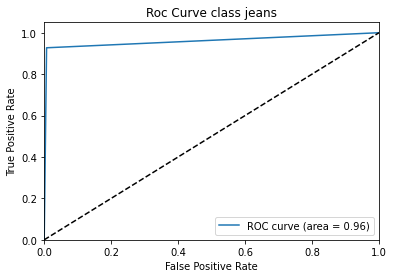

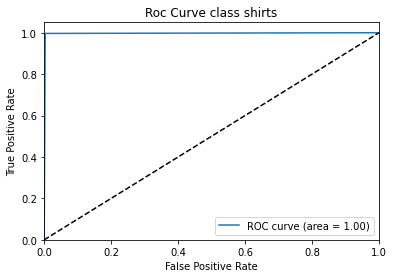

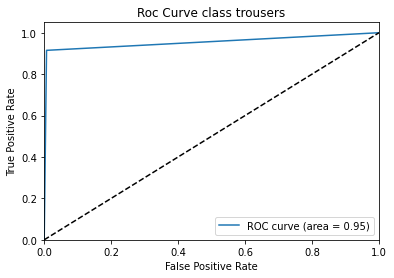

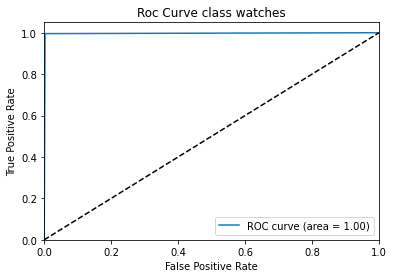

In [11]:
clf_svc=SVC(kernel='rbf', C=150, gamma='scale')
mean_svc,std_svc=compute_performance(clf_svc,strkf,X, y,i,j)
score_KFold.append((mean_svc,std_svc))

L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.97101449 0.96940419 0.96618357 0.96940419 0.97580645 0.95483871
 0.97096774 0.96451613 0.94677419 0.96451613]
Ottenendo un'accuratezza media di 0.965 con deviazione standard di 0.008
La migliore accuratezza e' 0.976 ottenuta nello split numero 5
Salvo il modello ottenuto nello split numero 5
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 5


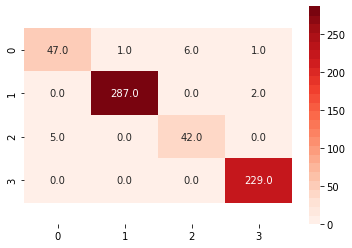

              precision    recall  f1-score   support

       jeans       0.90      0.85      0.88        55
      shirts       1.00      0.99      0.99       289
    trousers       0.88      0.89      0.88        47
     watches       0.99      1.00      0.99       229

    accuracy                           0.98       620
   macro avg       0.94      0.94      0.94       620
weighted avg       0.98      0.98      0.98       620



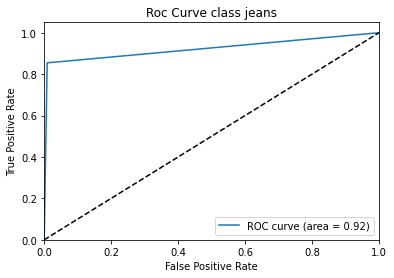

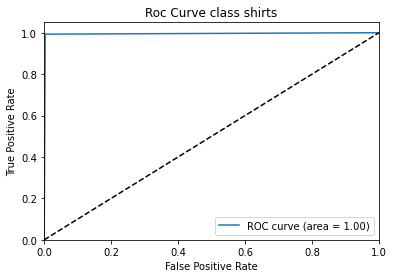

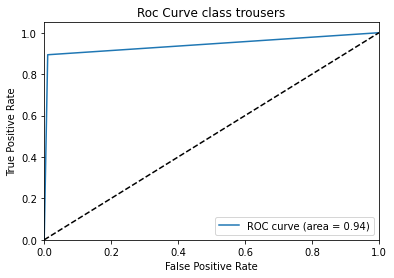

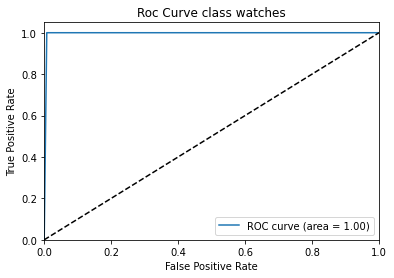

In [12]:
clf_knn=KNeighborsClassifier(n_neighbors=3, weights='distance',metric='manhattan')
mean_knn,std_knn=compute_performance(clf_knn,strkf,X, y,i,j)
score_KFold.append((mean_knn,std_knn))

Score per fold
L'accuratezza per ogni sacca della cross validation è rappresentata dal seguente vettore 
[0.9758453965187073, 0.9838969111442566, 0.977455735206604, 0.9710144996643066, 0.9822580814361572, 0.9822580814361572, 0.9854838848114014, 0.9887096881866455, 0.9661290049552917, 0.9741935729980469]
Ottenendo un'accuratezza media di 0.979 con deviazione standard di 0.007
La migliore accuratezza e' 0.989 ottenuta nello split numero 8
Salvo il modello ottenuto nello split numero 8
Si mostra ora la matrice di adiacenza ottenuta sul test set dello split numero 8


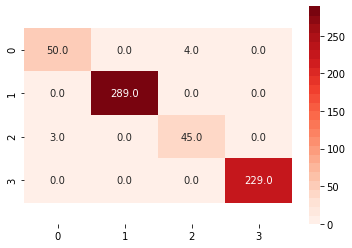

              precision    recall  f1-score   support

           0       0.94      0.93      0.93        54
           1       1.00      1.00      1.00       289
           2       0.92      0.94      0.93        48
           3       1.00      1.00      1.00       229

    accuracy                           0.99       620
   macro avg       0.97      0.97      0.97       620
weighted avg       0.99      0.99      0.99       620



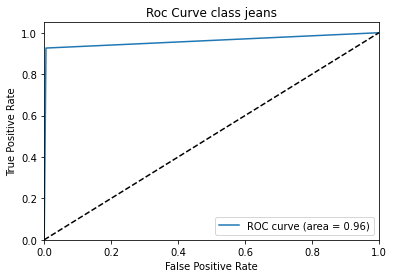

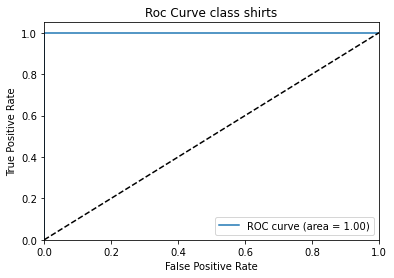

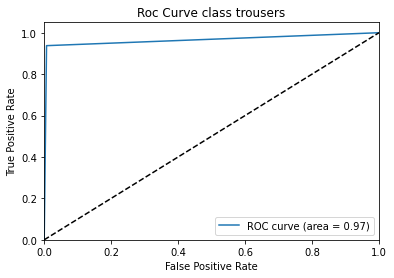

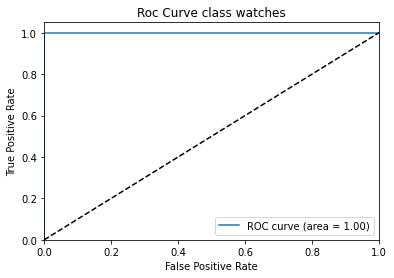

In [10]:
clf_nn=KerasClassifier(build_fn=create_network)
mean_nn,std_nn=compute_performance_nn(clf_nn,strkf,X, y,i,j)
score_KFold.append((mean_nn,std_nn))

In [18]:
score_df = pd.DataFrame(score_KFold,index=['NN','SVC','KNN','AdaBoost'],columns=['accuracy_mean','std'])
score_df.to_csv("/home/emiliocasella/Scrivania/proj204898/img/10fold.csv")
score_df.head()

,accuracy_mean,std
NN,0.979,0.007
SVC,0.977,0.004
KNN,0.965,0.008
AdaBoost,0.920,0.012


In [19]:
def tenFoldPlot(score_KFold,labels):
    values=[]
    for i,j in score_KFold:
        values.append(i)
        values.append(j)  
    plt.figure()
    c=['yellow','red','green','blue']
    data=np.array(values).reshape(len(labels),2)
    accuracy=data[:,0]
    stdr=data[:,1]
    std=data[:,1]/np.max(data[:,1])
    size=[50]*10  
    for i in range(len(c)):
        l=labels[i]
        acc=accuracy[i]
        sx=stdr[i]
        plt.scatter([acc],[acc],s=std[i]*acc*5000,color=[c[i]])
        st1="{0} Acc:{1:.2f}%".format(l,acc*100.0)
        st2="{0}std:{1:.3f}".format(" ",sx)
        plt.scatter([], [], color=[c[i]], s=std[i]*200,
                label=st1+" "+st2)
    plt.grid(linestyle="--")
    plt.legend(loc='lower left', bbox_to_anchor=(0.4, 1),
          ncol=1, fancybox=True, shadow=True)
    plt.axis([np.min(accuracy)-.05, np.max(accuracy)+.05,np.min(accuracy)-.05, np.max(accuracy)+.05])
    plt.show()

Come si evince da tutti i risultati  e i grafici precedenti, il modello migliore per accuratezza è rappresentato dalla rete neurale, seguita da SVC, KNN e AdaBoost.

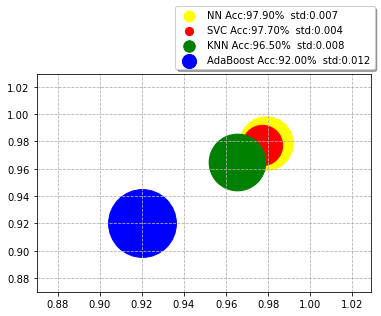

In [20]:
labels=score_df.index.values
tenFoldPlot(score_KFold,labels)

## Anomaly Detection

In [4]:
X,y,i,j=loadD(PATH)
col=[str(h) for h in range(i*j)]
dataFrame=pd.DataFrame(X,columns=col)
dataFrame['class']=y

Come richiesto dalla traccia progettuale, si cerca di identificare la classe più numerosa classificandola come coretta; le restanti classi rappresenteranno le anomalie.

Si mostra, tramite il grafico sottostante, che la classe jeans è quella che contiene più esempi.

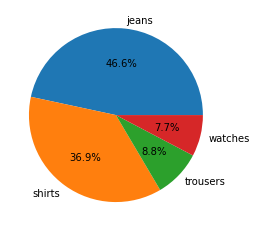

In [5]:
etichette, contatore = np.unique(y, return_counts=True)
contatore=np.sort(contatore)[::-1]
plt.pie(contatore,labels=etichette,autopct='%1.1f%%')
plt.show()

In [6]:
dataFrame["class"]=dataFrame["class"].replace(etichette[0],1)
dataFrame["class"]=dataFrame["class"].replace(etichette[1:],0)
correctData=dataFrame[dataFrame["class"]==1]
anomalyData=dataFrame[dataFrame["class"]==0]

Si mostra ora la composizione del nuovo dataset ottenuto, tramite il grafico sottostante ottenuto tramite PCA.

L’analisi delle componenti principali (PCA) è un metodo che rientra nei problemi di trasformazione lineare che viene ampiamente utilizzata in diversi campi, soprattutto per l’estrazione delle caratteristiche e la riduzione della dimensionalità.

PCA permette di trovare le direzioni della massima varianza nei dati ad alta dimensione e di proiettarle su un nuovo sottospazio con dimensioni uguali o inferiori a quello originale.

Utilizzando la proiezione matematica, il set di dati originale, che potrebbe aver coinvolto molte variabili, viene ad essere interpretato solo da poche variabili (dette componenti principali).

L’output di PCA sono proprio queste componenti principali, il cui numero è inferiore o uguale al numero di variabili originali. 

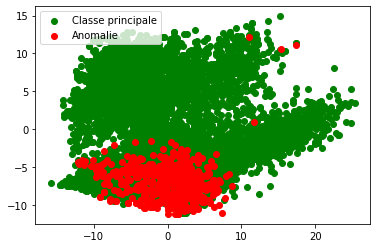

In [7]:
pca = PCA(n_components=2)
components = pca.fit_transform(dataFrame)

row = 0
col = 1

plt.scatter(components[:,row][dataFrame["class"]==0],components[:,col][dataFrame["class"]==0],c='g',label='Classe principale')
plt.scatter(components[:,row][dataFrame["class"]==1],components[:,col][dataFrame["class"]==1],c='r',label='Anomalie')
plt.legend(loc="upper left")
plt.show()

Si effettuano due tipologie di analisi:
    
1) Approccio tramite rete densa con il compito di comprimere e riespandere l'output.
   Il modello viene allenato per poche epoche,6, e presenta una loss mse, che si comporta molto bene nella "ricostruzione" ed
   analisi delle immagini;


2) Approccio tramite un classificatore PCA.

In [12]:
def bestPCA(correctData_X_train,correctData_X_test,anomalyData_X,correctData_y_test,anomalyData_y):
    indexR=[]
    roc=[]
    for i in range (300,500,2):
        model = PCA(n_components=i)
        model.fit(correctData_X_train)
        values=np.concatenate((correctData_X_test,anomalyData_X))
        labels=np.concatenate((correctData_y_test,anomalyData_y))
        predictions=model.inverse_transform(model.transform(values))
        roc.append(roc2(values,predictions,labels))
        indexR.append(i)
    return indexR[np.argmax(roc)]

def plotErrAnom(correct_error,anomaly_error):
    plt.plot(correct_error,color="green",label='Errori correctData')
    plt.plot(np.arange(len(correct_error),len(correct_error)+len(anomaly_error)),anomaly_error,color="red",label='Errori anomalyData')
    plt.legend(loc="upper left")
    plt.show()
    

def train_anomaly(correctData):
    y = correctData['class']
    X=correctData.drop("class",axis=1).values
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,shuffle=True)
    
    my_init = keras.initializers.glorot_uniform(seed=1)
    autoenc = keras.models.Sequential()
    autoenc.add(keras.layers.Dense(input_dim=i*j, units=100, activation='tanh', kernel_initializer=my_init))
    autoenc.add(keras.layers.Dense(units=2400,activation='tanh', kernel_initializer=my_init))
    autoenc.add(keras.layers.Dense(units=100,activation='tanh', kernel_initializer=my_init))
    autoenc.add(keras.layers.Dense(units=50,activation='tanh', kernel_initializer=my_init))
    autoenc.add(keras.layers.Dense(units=100,activation='tanh', kernel_initializer=my_init)) 
    autoenc.add(keras.layers.Dense(units=2400,activation='tanh', kernel_initializer=my_init))
    autoenc.add(keras.layers.Dense(units=i*j,activation='tanh', kernel_initializer=my_init)) 
    autoenc.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0.000001)
    history=autoenc.fit(X_train,X_train,epochs=6,validation_data = (X_test, X_test),callbacks=[reduce_lr],verbose=0)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return autoenc
    
    
def mean_squared_err(true,pred):
    err=[]
    col=true.shape[1]
    true=list(true)
    pred=list(pred)
    for i in range(len(true)):
        p=pred[i]
        t=true[i]
        e=p-t
        e=e**2
        e=np.sum(e)
        e=e/col
        err.append(e)
    return np.array(err)  

def roc(values,predictions,labels):
    error= mean_squared_err(values,predictions)
    roc_x=[]
    roc_y=[]
    roc=0
    oldfpr=0
    oldtpr=0
    steps=100
    scaler = MinMaxScaler(feature_range=(0,1))
    error =1- scaler.fit_transform(error.reshape(-1,1))
    fpr,tpr,th=metrics.roc_curve(labels,error)
    for i in range(len(fpr)):
        FPR,TPR=fpr[i],tpr[i]
        roc+=(TPR+oldtpr)*(FPR-oldfpr)/2
        oldfpr=FPR
        oldtpr=TPR
        roc_x.append(FPR)
        roc_y.append(TPR)        
    plt.plot([0]+roc_x, [0]+roc_y, label='ROC curve (area = %0.3f)' % roc)
    plt.plot([0,1], [0,1], linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower left")
    plt.show()
    return roc

def roc2(values,predictions,labels):
    error= mean_squared_err(values,predictions)
    roc_x=[]
    roc_y=[]
    roc=0
    oldfpr=0
    oldtpr=0
    steps=100
    scaler = MinMaxScaler(feature_range=(0,1))
    error =1- scaler.fit_transform(error.reshape(-1,1))
    fpr,tpr,th=metrics.roc_curve(labels,error)
    for i in range(len(fpr)):
        FPR,TPR=fpr[i],tpr[i]
        roc+=(TPR+oldtpr)*(FPR-oldfpr)/2
        oldfpr=FPR
        oldtpr=TPR
        roc_x.append(FPR)
        roc_y.append(TPR)        
    return roc

def thresholdErr(error,max_threshold):
    x=[]
    for i in error:
        if(i>max_threshold):
            x.append(0)
        else:
            x.append(1)
    return x

class MyClassificatorAnomaly(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, correctData, anomalyData):
        return self

    def transform(self, correctData, anomalyData,num):
        correctData_y=correctData['class']
        correctData_X=correctData.drop("class",axis=1).values
        correctData_X_train,correctData_X_test,correctData_y_train,correctData_y_test=train_test_split(correctData_X,correctData_y,test_size=0.05,shuffle=True)
        anomalyData_y=anomalyData['class']
        anomalyData_X=anomalyData.drop("class",axis=1).values
        anomalyData_X_train,anomalyData_X_test,anomalyData_y_train,anomalyData_y_test=train_test_split(anomalyData_X,anomalyData_y,test_size=0.2,shuffle=True)
        if(num==0):
            print("Anomaly detections with MSE...")
            model=train_anomaly(correctData)
            predicted_correct=model.predict(correctData_X_test)
            predicted_anomaly=model.predict(anomalyData_X)
            correct_error= mean_squared_err(correctData_X_test,predicted_correct)
            anomaly_error= mean_squared_err(anomalyData_X,predicted_anomaly)
            values=np.concatenate((correctData_X_test,anomalyData_X))
            labels=np.concatenate((correctData_y_test,anomalyData_y))
            predictions=model.predict(values)
        else:
            print("Tuning anomaly detections with PCA...")
            best=bestPCA(correctData_X_train,correctData_X_test,anomalyData_X,correctData_y_test,anomalyData_y)
            print("Best PCA values "+ str(best))
            model = PCA(n_components=best)
            model.fit(correctData_X_train)
            predicted_correct=model.inverse_transform(model.transform(correctData_X_test))
            predicted_anomaly=model.inverse_transform(model.transform(anomalyData_X))
            correct_error= mean_squared_err(correctData_X_test,predicted_correct)
            anomaly_error= mean_squared_err(anomalyData_X,predicted_anomaly)
            values=np.concatenate((correctData_X_test,anomalyData_X))
            labels=np.concatenate((correctData_y_test,anomalyData_y))
            predictions=model.inverse_transform(model.transform(values))
        print("done!")
        return model,correct_error,anomaly_error,values,predictions,labels

La divisione, per entrambi i classificatori, è costitutita da un set che presenta molte anomalie e minori esempi corretti, in modo tale da avere risultati affidabili sia in fase di train che di test di entrambi gli approcci.

Anomaly detections with MSE...


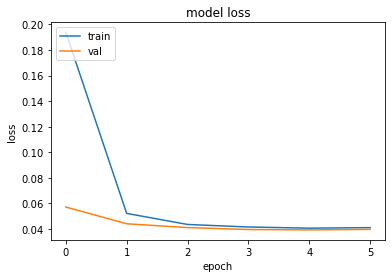

done!


In [13]:
model1,correct_error1,anomaly_error1,values1,predictions1,labels1=MyClassificatorAnomaly().transform(correctData, anomalyData,0)

Il grafico sottostante permette di studiare la soglia degli errori commessi su entrambe le classi e definirne un limite, soprattutto per la classe corretta.
Si puo' notare una soglia massima di errore sulla classe corretta dello 0,07 circa; un discreto risultato.

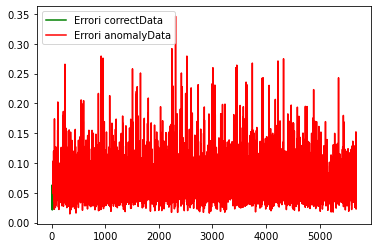

In [14]:
plotErrAnom(correct_error1,anomaly_error1)

Le considerazioni precedenti, sono confermate dalla curva di roc sottostante, presentando un risultato moderatamente accurato.

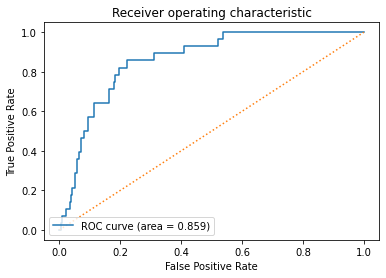

0.8586959266648146

In [15]:
roc(values1,predictions1,labels1)

Si passa ora all'analisi tramite PCA.
Il tuning della rete viene effettuato testando vari numeri di features, scegliendo quello che presenta uno score migliore, in questo caso 496.

In [12]:
model2,correct_error2,anomaly_error2,values2,predictions2,labels2=MyClassificatorAnomaly().transform(correctData, anomalyData,1)

Tuning anomaly detections with PCA...
Best PCA values 496
done!


La soglia dell'errore sulla classe positiva è molto bassa, quasi vicina allo zero, mostrando un risultato migliore della metodologia precedente.

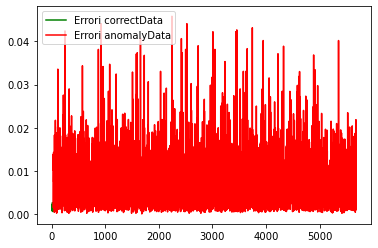

In [13]:
plotErrAnom(correct_error2,anomaly_error2)

La curva di ROC conferma tutto questo,mostrando un risultato altamente accurato.

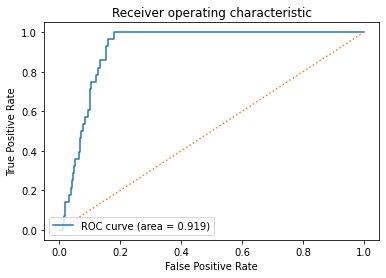

0.9187353215990303

In [14]:
roc(values2,predictions2,labels2)

Viene salvato, quindi, il modello PCA prodotto.

In [20]:
saveM(model2,"BestAnomayModel")

Impostando una soglia di errore massima, si può notare come l'accuratezza del modello salvato sia quasi perfetta, confermando ulteriormente le considerazioni precedenti.

In [29]:
y = dataFrame["class"]
X = dataFrame.drop("class",axis=1).values
anomaly_detection=loadM("BestAnomayModel")
pred=anomaly_detection.inverse_transform(anomaly_detection.transform(X))
err= mean_squared_err(X,pred)
y_pred=(np.array(thresholdErr(err,0.0001)))
accuracy_anomaly=accuracy_score(y,y_pred)*100
print(str(np.round(accuracy_anomaly,3))+" % ")

99.468 % 
